In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import (
    ElasticNet,
    Lasso,
    LinearRegression,
    Ridge
)
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
    QuantileTransformer
)

from src.config import DADOS_CATEGORIZADOS
from src.modelos import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao
)

sns.set_theme(palette='bright')

RANDOM_STATE = 42

In [2]:
df = pd.read_parquet(DADOS_CATEGORIZADOS)

df.head()

,idade,sexo,imc,pressao_media,colesterol_total,ldl,hdl,triglicerides,glicose,target,colesterol_hdl_cat
0,59,2,32.099998,101.0,157,93.199997,38.0,4.8598,87,151,4-5
1,48,1,21.600000,87.0,183,103.199997,70.0,3.8918,69,75,2-3
2,72,2,30.500000,93.0,156,93.599998,41.0,4.6728,85,141,4-5
3,24,1,25.299999,84.0,198,131.399994,40.0,4.8903,89,206,4-5
4,50,1,23.000000,101.0,192,125.400002,52.0,4.2905,80,135,4-5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   idade               442 non-null    int8    
 1   sexo                442 non-null    int8    
 2   imc                 442 non-null    float32 
 3   pressao_media       442 non-null    float32 
 4   colesterol_total    442 non-null    int16   
 5   ldl                 442 non-null    float32 
 6   hdl                 442 non-null    float32 
 7   triglicerides       442 non-null    float32 
 8   glicose             442 non-null    int8    
 9   target              442 non-null    int16   
 10  colesterol_hdl_cat  442 non-null    category
dtypes: category(1), float32(5), int16(2), int8(3)
memory usage: 12.3 KB


In [4]:
X = df.drop(columns='target')
y = df['target']

In [5]:
colunas_power_transform = ['imc', 'ldl', 'hdl', 'colesterol_total']

coluna_target = ['target']

coluna_ordinal_encoder = ['colesterol_hdl_cat']

coluna_one_hot_encoder = ['sexo']

colunas_standard_scaler = [
    coluna for coluna in df.columns
        if coluna not in colunas_power_transform + coluna_target + coluna_ordinal_encoder + coluna_one_hot_encoder
]

colunas_standard_scaler

['idade', 'pressao_media', 'triglicerides', 'glicose']

In [6]:
categorias_ordinal_encoder = [
    ['2-3', '4-5', '6+']
]

In [7]:
preprocessamento_categoricas = ColumnTransformer(
    transformers = [
        ('ordinal_encoder', OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
        ('one_hot_encoder', OneHotEncoder(drop='if_binary'), coluna_one_hot_encoder)
    ],
    remainder='passthrough'
)

preprocessamento_simples = ColumnTransformer(
    transformers = [
        ('ordinal_encoder', OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
        ('one_hot_encoder', OneHotEncoder(drop='if_binary'), coluna_one_hot_encoder),
        ('standard_scaler', StandardScaler(), X.columns.difference(coluna_ordinal_encoder + coluna_one_hot_encoder))
    ],
    remainder='passthrough'
)

preprocessamento_completo = ColumnTransformer(
    [
        ('power_transform', PowerTransformer(method='box-cox'), colunas_power_transform),
        ('standard_scaler', StandardScaler(), colunas_standard_scaler),
        ('ordinal_encoder', OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
        ('one_hot_encoder', OneHotEncoder(drop='if_binary'), coluna_one_hot_encoder)
    ]
)

In [8]:
target_transformer = QuantileTransformer(n_quantiles=20, output_distribution='normal')

In [43]:
regressors = {
    # DummyRegressor
    'DummyRegressor': {
        'preprocessor': None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None
    },
    # LinearRegression
    'LinearRegression_pre_cat': {
        'preprocessor': preprocessamento_categoricas,
        'regressor': LinearRegression(),
        'target_transformer': None
    },
    'LinearRegression_pre_simples': {
        'preprocessor': preprocessamento_simples,
        'regressor': LinearRegression(),
        'target_transformer': None
    },
    'LinearRegression_pre_completo': {
        'preprocessor': preprocessamento_completo,
        'regressor': LinearRegression(),
        'target_transformer': None
    },
    'LinearRegression_pre_completo_target': {
        'preprocessor': preprocessamento_completo,
        'regressor': LinearRegression(),
        'target_transformer': target_transformer
    },
    # Lasso
    'Lasso_pre_cat': {
        'preprocessor': preprocessamento_categoricas,
        'regressor': Lasso(),
        'target_transformer': None
    },
    'Lasso_pre_simples': {
        'preprocessor': preprocessamento_simples,
        'regressor': Lasso(),
        'target_transformer': None
    },
    'Lasso_pre_completo': {
        'preprocessor': preprocessamento_completo,
        'regressor': Lasso(),
        'target_transformer': None
    },
    'Lasso_pre_completo_target': {
        'preprocessor': preprocessamento_completo,
        'regressor': Lasso(),
        'target_transformer': target_transformer
    },
    'Lasso_pre_completo_target_hiper': {
        'preprocessor': preprocessamento_completo,
        'regressor': Lasso(alpha=0.1),
        'target_transformer': target_transformer
    },
    # Ridge
    'Ridge_pre_cat': {
        'preprocessor': preprocessamento_categoricas,
        'regressor': Ridge(),
        'target_transformer': None
    },
    'Ridge_pre_simples': {
        'preprocessor': preprocessamento_simples,
        'regressor': Ridge(),
        'target_transformer': None
    },
    'Ridge_pre_completo': {
        'preprocessor': preprocessamento_completo,
        'regressor': Ridge(),
        'target_transformer': None
    },
    'Ridge_pre_completo_target': {
        'preprocessor': preprocessamento_completo,
        'regressor': Ridge(),
        'target_transformer': target_transformer
    },
    'Ridge_pre_completo_target_hiper': {
        'preprocessor': preprocessamento_completo,
        'regressor': Ridge(alpha=0.1),
        'target_transformer': target_transformer
    },
    # ElasticNet
    'ElasticNet_pre_cat': {
        'preprocessor': preprocessamento_categoricas,
        'regressor': ElasticNet(),
        'target_transformer': None
    },
    'ElasticNet_pre_simples': {
        'preprocessor': preprocessamento_simples,
        'regressor': ElasticNet(),
        'target_transformer': None
    },
    'ElasticNet_pre_completo': {
        'preprocessor': preprocessamento_completo,
        'regressor': ElasticNet(),
        'target_transformer': None
    },
    'ElasticNet_pre_completo_target': {
        'preprocessor': preprocessamento_completo,
        'regressor': ElasticNet(),
        'target_transformer': target_transformer
    },
    'ElasticNet_pre_completo_target_hiper': {
        'preprocessor': preprocessamento_completo,
        'regressor': ElasticNet(alpha=0.1),
        'target_transformer': target_transformer
    },
}

In [44]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

In [45]:
df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.003524,0.004551,-0.011963,-64.006461,-73.222493,0.008075
1,DummyRegressor,0.002529,0.006186,-0.026978,-70.577936,-80.043187,0.008715
2,DummyRegressor,0.00299,0.003707,-0.015304,-59.829545,-74.338597,0.006697
3,DummyRegressor,0.004029,0.003616,-0.000212,-70.053929,-82.047452,0.007646
4,DummyRegressor,0.002546,0.003007,-0.042316,-65.425655,-76.315297,0.005553
...,...,...,...,...,...,...,...
95,ElasticNet_pre_completo_target_hiper,0.050318,0.013262,0.457938,-42.784609,-53.590375,0.063581
96,ElasticNet_pre_completo_target_hiper,0.046138,0.012183,0.508717,-44.964482,-55.361732,0.058321
97,ElasticNet_pre_completo_target_hiper,0.040857,0.008047,0.324929,-50.487402,-60.616531,0.048904
98,ElasticNet_pre_completo_target_hiper,0.03562,0.006489,0.589138,-43.288833,-52.58564,0.042109


In [46]:
df_resultados['model_group'] = df_resultados['model'].str.split('_').str[0]

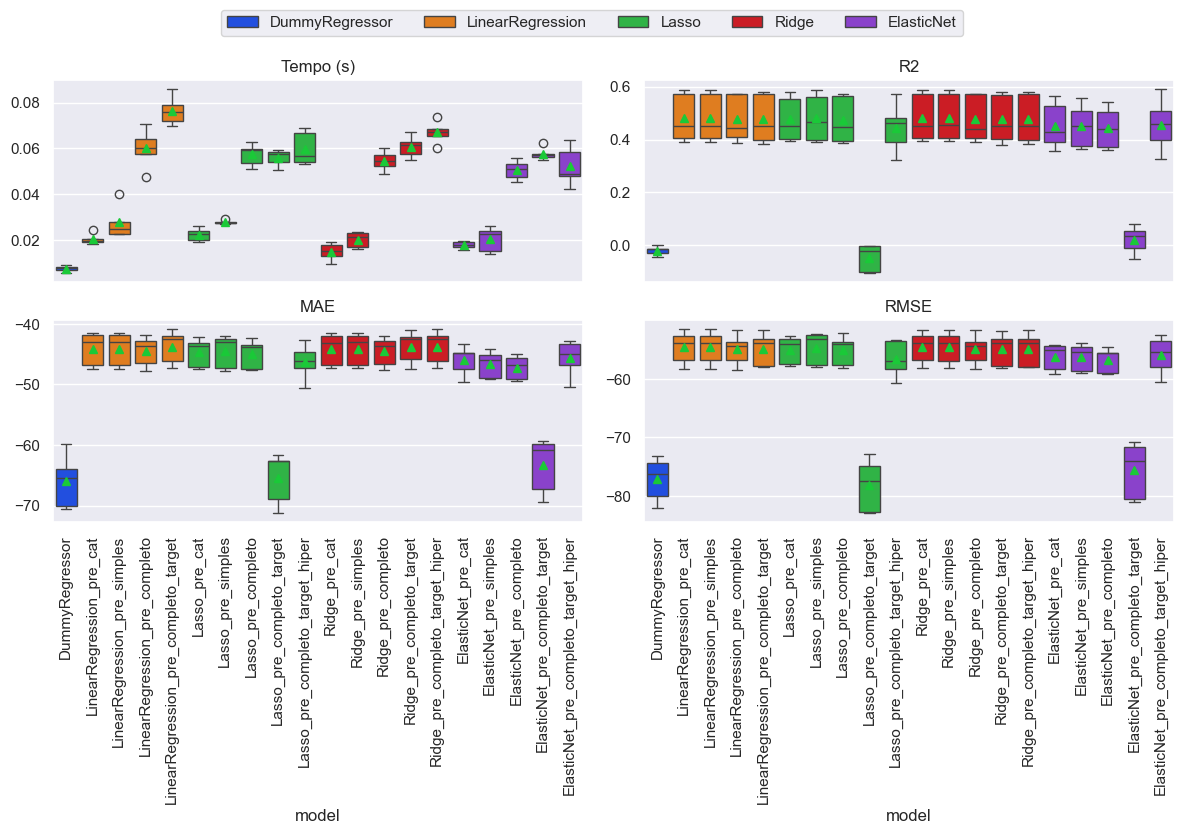

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

comparar_metricas = [
    'time_seconds',
    'test_r2',
    'test_neg_mean_absolute_error',
    'test_neg_root_mean_squared_error'
]

nomes_metricas = [
    'Tempo (s)',
    'R2',
    'MAE',
    'RMSE'
]

for ax, metrica, nome in zip(axs.flatten(), comparar_metricas, nomes_metricas):
    sns.boxplot(
        x='model',
        y=metrica,
        data=df_resultados,
        ax=ax,
        showmeans=True,
        hue='model_group'
    )
    ax.set_title(nome)
    ax.set_ylabel('')#nome)
    ax.tick_params(axis='x', rotation=90)

    legend = ax.get_legend()
    labels = [text.get_text() for text in legend.get_texts()]
    ax.get_legend().remove()

fig.legend(
    handles = legend.legend_handles,
    labels=labels,
    loc='upper center',
    ncol=5,
    bbox_to_anchor=(0.5, 1.05)
)

plt.tight_layout()
plt.show()